<a href="https://colab.research.google.com/github/dkrieger94/intro/blob/master/EarthSystemModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.special import erf

import matplotlib.pyplot as plt

A = 204.    # Budyko approximation constants       (W / m**2)
B = 2.17

a = 5.4     # constant for OLR modification by CO2 (W / m**2)

sigma = 5.6703726226e-08    # Stefan-Boltzmann constant (W / m**2 / K**4)
S0 = 1365.2                 # solar constant (W / m**2)
emss = 0.6                  # atmosphere emissivity

rho_w = 1028.               # density of water (kg / m**3)
cw = 4200                   # specific heat of liquid water (J / kg / K)

# Some useful time conversion factors
seconds_per_minute = 60.
minutes_per_hour = 60.
hours_per_day = 24.
days_per_year = 365.2422
seconds_per_hour = minutes_per_hour * seconds_per_minute
minutes_per_day = hours_per_day * minutes_per_hour
seconds_per_day = hours_per_day * seconds_per_hour
seconds_per_year = seconds_per_day * days_per_year


class ESM:

    def __init__(self,
                 solar_cnst=0.25 * S0,
                 albedo_atm=0.1,
                 albedo_land=0.3,
                 albedo_icefree=0.2,
                 albedo_ice=0.6,
                 albedo_ref_temperature=268.15,
                 albedo_b=0.05,
                 albedo_carbon_coeff=-0.01,
                 emissivity=emss,
                 depth_s=50.0,
                 depth_d=3450.0,
                 initial_state=(255., 243.),
                 co2=400.0,
                 transient_rad_resp=0.0,
                 mixing_scale=3.2,
                 lin_olr=False,
                 use_constant_albedo_land=False,
                 use_constant_albedo_icefree=False):
      
        self.model_state = initial_state

        if np.isscalar(self.model_state):
            self.Ts = self.model_state
            # ocean layer initialized to be 10 degrees colder than the surface layer
            self.Td = self.Ts - 10.0
            self.stand_alone_atmosphere = True
        else:
            assert len(self.model_state) == 2
            self.Ts, self.Td = self.model_state
            self.stand_alone_atmosphere = False

        self.albedo_atm = albedo_atm  # atmospheric albedo
        self.albedo_land = albedo_land
        self.albedo_icefree = albedo_icefree  # land albedo in hothouse climate
        self.albedo_ice = albedo_ice  # land albedo in snowball climate
        self.albedo_ref_temperature = albedo_ref_temperature  # reference temperature for albedo transition zone
        self.albedo_b = albedo_b  # albedo error function tuning parameter
        self.albedo_carbon_coeff = albedo_carbon_coeff  # albedo dependence on carbon
        self.use_constant_albedo_land = use_constant_albedo_land
        self.use_constant_albedo_icefree = use_constant_albedo_icefree

        self.solar_cnst = solar_cnst
        self.lin_olr = lin_olr

        # effective emiss. * Stefan-Boltzmann constant
        self.emss_cns = 1.0 - 0.5 * emissivity

        self.co2 = co2  # co2 concentration in ppmv

        self.eta = mixing_scale
        self.lambda_t = transient_rad_resp

        # Time scales
        self.depth_s = depth_s    # characteristic depth for Ts   (m)
        self.tau_s = self.depth_s * rho_w * cw # time scale for integration

        self.depth_d = depth_d      # characteristic depth for Ts   (m)
        self.tau_d = self.depth_d * rho_w * cw # time scale for integration

    #---------------------------------------------------------------------------
    #------------------   Definition of model processes    ---------------------
    #---------------------------------------------------------------------------
    def compute_albedo(self, t):
        return self.albedo_atm + self.compute_albedo_land(t) * (1 - self.albedo_atm) ** 2

    def compute_albedo_land(self, t):
        if self.use_constant_albedo_land:
            return self.albedo_land
        else:
            tmp = erf(self.albedo_b * (t - self.albedo_ref_temperature))
            tmp = self.albedo_ice * (1.0 - tmp) + self.compute_albedo_icefree() * (1.0 + tmp)
            return tmp / 2.0

    def compute_albedo_icefree(self):
        if self.use_constant_albedo_icefree:
            return self.albedo_icefree
        elif self.co2 <= 1:
            return self.albedo_icefree
        else:
            return self.albedo_icefree + self.albedo_carbon_coeff * np.log(self.co2)

    def compute_ASR(self, t):
        return (1 - self.compute_albedo(t)) * self.solar_cnst

    def compute_OLR(self, t):
        if self.lin_olr:
            return A + B * (t - 273.15)
        if self.co2 > 1:
            return self.emss_cns * sigma * t ** 4 - a * np.log(self.co2)
        else:
            return self.emss_cns * sigma * t ** 4

    def compute_NRI(self, ts):
        return  self.compute_ASR(ts) - self.compute_OLR(ts)

    def compute_DSI(self, ts, td):
        t_delta = ts - td
        return self.eta * t_delta + self.lambda_t * t_delta

    def compute_imbalance(self, state):

        if self.stand_alone_atmosphere:
            return self.compute_NRI(state) / self.tau_s
        else:
            ts, td = state
            Ns = self.compute_NRI(ts) / self.tau_s
            Nd = self.compute_DSI(ts, td) / self.tau_d
            return np.array([Ns - Nd, Nd])

    def model_info(self):
        print("Running stand-alone atmosphere: ", self.stand_alone_atmosphere)
        print('Surface temperature: ', self.Ts, ' [K]')
        print('Ocean temperature: ', self.Td, ' [K]')
        print('Surface albedo: ', self.compute_albedo(self.Ts), ' [-]')
        print('Land albedo: ', self.compute_albedo_land(self.Ts), ' [-]')
        if self.co2 > 1:
          print('CO2: ', self.co2, ' [ppmv]')
        print('ASR: ', self.compute_ASR(self.Ts), ' [W/m^2]' )
        print('OLR: ', self.compute_OLR(self.Ts), ' [W/m^2]' )
        print('NRI: ', self.compute_NRI(self.Ts), ' [W/m^2]' )
        print('DSI: ', self.compute_DSI(self.Ts, self.Td), ' [W/m^2]' )

    #---------------------------------------------------------------------------
    #------------------          Model numerics            ---------------------
    #---------------------------------------------------------------------------

    def integrate(self, sim_time=1.0, out_freq=None,
                  update_state=True, verbose=False):
        '''
            sim_time: integration time as a fraction of the time_scale
        '''

        # store of time array:
        if out_freq is None:
            time = np.array([0.0, sim_time,])
        else:
            time = np.arange(0.0, sim_time, out_freq)

        time_scale = seconds_per_year
        
        # storing a copy of initial condition:
        Tstart = self.model_state

        # construct callable function for rhs (model tendencies):        
        rhs = lambda t, x: self.compute_imbalance(x) * time_scale

        # Integrate using odeint: (stiffness is no longer a problem here!)
        (Tequim, info) = odeint(rhs, Tstart, time,
                                Dfun=None,
                                full_output=True,
                                printmessg=verbose, tfirst=True)
        Tequim = Tequim.squeeze()

        if verbose:
            print(info)

        if update_state:
            # update model Equilibrium Temperature with last computed stage:
            self.model_state = Tequim[-1]
            self.Ts, self.Td = self.model_state

        # return specified integration time-series:
        if time.size > 2:
            return time, Tequim
        else:
            return Tequim[-1]

if __name__ == "__main__":

    model = ESM(initial_state=255.0, lin_olr=True)

    model.model_info()



Running stand-alone atmosphere:  True
Surface temperature:  255.0  [K]
Ocean temperature:  245.0  [K]
Surface albedo:  0.5203505387443385  [-]
Land albedo:  0.5189512824004178  [-]
CO2:  400.0  [ppmv]
ASR:  163.7043611265573  [W/m^2]
OLR:  164.61450000000005  [W/m^2]
NRI:  -0.9101388734427474  [W/m^2]
DSI:  32.0  [W/m^2]


# Old Exercise 1

Text(0, 0.5, 'dN/dT')

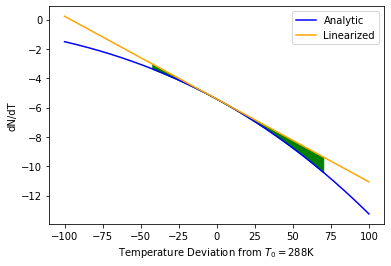

In [ ]:
t0 = 288

def linear_approx(t0=288, dt=100, sigma=sigma, S0=S0):
    dt_steps = np.linspace(-dt, dt, 1000)
    dndt_analytic = -4 * sigma * (dt_steps + t0) ** 3
    dndt_linearized = -4 * sigma * t0 ** 3 - dt_steps * 12 * sigma * t0 ** 2
    return dt_steps, dndt_analytic, dndt_linearized

dt, dndt_an, dndt_lin = linear_approx(t0=t0)

plt.plot(dt, dndt_an, ls='solid', color='blue', label='Analytic')
plt.plot(dt, dndt_lin, ls='solid', color='orange', label='Linearized')
plt.fill_between(dt, dndt_lin, dndt_an, where=np.abs((dndt_lin-dndt_an)/dndt_an) <= 0.1, color='green')
plt.legend()
plt.xlabel(f'Temperature Deviation from $T_0={t0}$K')
plt.ylabel('dN/dT')

# Old Exercise 2

In [ ]:
for t_target in [288, 290.5]:

    emss_low = 0.3
    emss_high = 0.9

    t_dif = 10 # arbitrary starting value, should be higher than value in while condition

    while np.abs(t_dif) > 0.01:
        new_emss = 0.5*(emss_low+emss_high)
        model = ESM(initial_state=255.0, emissivity=new_emss)
        temp_eq = model.integrate(sim_time=25., out_freq=None, update_state=False, verbose=False)

        t_dif = temp_eq - t_target
        print(f"Emissivity {new_emss:.4f}, Eq. Temp: {temp_eq:.4f}K, Difference: {t_dif:.4f}K")

        if t_dif > 0:
            emss_high = new_emss
        else:
            emss_low = new_emss

    print(f"Required emissivity for {t_target}K: {new_emss:.4f}")


Emissivity 0.6000, Eq. Temp: 293.9839K, Difference: 5.9839K
Emissivity 0.4500, Eq. Temp: 282.4785K, Difference: -5.5215K
Emissivity 0.5250, Eq. Temp: 289.0401K, Difference: 1.0401K
Emissivity 0.4875, Eq. Temp: 286.2326K, Difference: -1.7674K
Emissivity 0.5062, Eq. Temp: 287.6862K, Difference: -0.3138K
Emissivity 0.5156, Eq. Temp: 288.3728K, Difference: 0.3728K
Emissivity 0.5109, Eq. Temp: 288.0322K, Difference: 0.0322K
Emissivity 0.5086, Eq. Temp: 287.8599K, Difference: -0.1401K
Emissivity 0.5098, Eq. Temp: 287.9462K, Difference: -0.0538K
Emissivity 0.5104, Eq. Temp: 287.9892K, Difference: -0.0108K
Emissivity 0.5106, Eq. Temp: 288.0107K, Difference: 0.0107K
Emissivity 0.5105, Eq. Temp: 288.0000K, Difference: -0.0000K
Required emissivity for 288K: 0.5105
Emissivity 0.6000, Eq. Temp: 293.9839K, Difference: 3.4839K
Emissivity 0.4500, Eq. Temp: 282.4785K, Difference: -8.0215K
Emissivity 0.5250, Eq. Temp: 289.0401K, Difference: -1.4599K
Emissivity 0.5625, Eq. Temp: 291.5770K, Difference: 1.

Text(0, 0.5, 'Equilibrium temperaure [K]')

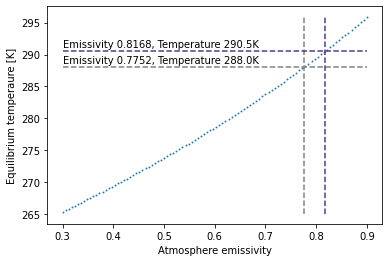

In [ ]:
emss_arr = np.linspace(0.3, 0.9, 100)

temp_eq = np.empty_like(emss_arr)

for i, emss in enumerate(emss_arr):

    model = ESM(initial_state=255.0, emissivity=emss)
    temp_eq[i] = model.integrate(sim_time=25., out_freq=None, update_state=False, verbose=False)


# tau = 1.0 - 0.5 * emss_arr
plt.scatter(emss_arr, temp_eq, s=0.8)
plt.hlines(288.0, emss_arr.min(), emss_arr.max(), colors='gray', linestyles='dashed', label='')
plt.vlines(0.7752, 265., 296., colors='gray', linestyles='dashed', label='')
plt.hlines(290.5, emss_arr.min(), emss_arr.max(), colors='darkslateblue', linestyles='dashed', label='')
plt.vlines(0.8168, 265., 296., colors='darkslateblue', linestyles='dashed', label='')

plt.annotate('Emissivity 0.7752, Temperature 288.0 [K]', xy=(0.3, 288.7), xycoords='data')
plt.annotate('Emissivity 0.8168, Temperature 290.5 [K]', xy=(0.3, 291.2), xycoords='data')

plt.xlabel("Atmosphere emissivity")
plt.ylabel("Equilibrium temperaure [K]")


# Old Exercise 3 and some general tests

Running stand-alone atmosphere:  True
Surface temperature:  255.0  [K]
Ocean temperature:  245.0  [K]
Surface albedo:  0.5203505387443385  [-]
Land albedo:  0.5189512824004178  [-]
CO2:  400.0  [ppmv]
ASR:  163.7043611265573  [W/m^2]
OLR:  135.47638754405622  [W/m^2]
NRI:  28.22797358250108  [W/m^2]
DSI:  32.0  [W/m^2]
-------------------------------------------------------------------
Running stand-alone atmosphere:  True
Surface temperature:  255.0  [K]
Ocean temperature:  245.0  [K]
Surface albedo:  0.5203505387443385  [-]
Land albedo:  0.5189512824004178  [-]
CO2:  400.0  [ppmv]
ASR:  163.7043611265573  [W/m^2]
OLR:  135.47638754405622  [W/m^2]
NRI:  28.22797358250108  [W/m^2]
DSI:  32.0  [W/m^2]
Running stand-alone atmosphere:  True
Surface temperature:  255.0  [K]
Ocean temperature:  245.0  [K]
Surface albedo:  0.5203505387443385  [-]
Land albedo:  0.5189512824004178  [-]
CO2:  400.0  [ppmv]
ASR:  163.7043611265573  [W/m^2]
OLR:  135.47638754405622  [W/m^2]
NRI:  28.2279735825010

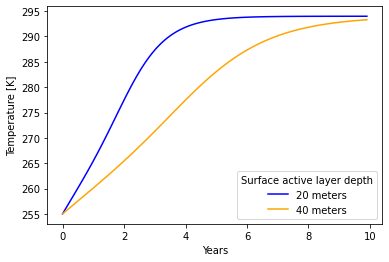

In [ ]:
model = ESM(initial_state=255.0, lin_olr=False, depth_s=20.)

model.model_info()

time, temperature_0 = model.integrate(sim_time=10., out_freq=.1, update_state=False, verbose=False)

print('-------------------------------------------------------------------')
model.model_info()


model = ESM(initial_state=255.0, lin_olr=False, depth_s=40.)

model.model_info()

time, temperature_1 = model.integrate(sim_time=10., out_freq=.1, update_state=False, verbose=False)

print('-------------------------------------------------------------------')
model.model_info()

plt.plot(time, temperature_0, ls='solid', color='blue', label="20 meters")
plt.plot(time, temperature_1, ls='solid', color='orange', label="40 meters")

plt.xlabel('Years')
plt.ylabel('Temperature [K]')
plt.legend(title='Surface active layer depth')

Running stand-alone atmosphere:  True
Surface temperature:  225.0  [K]
Ocean temperature:  215.0  [K]
Surface albedo:  0.585575399214388  [-]
Land albedo:  0.5994758014992444  [-]
CO2:  400.0  [ppmv]
ASR:  141.4431162481294  [W/m^2]
OLR:  69.3739052886443  [W/m^2]
NRI:  72.0692109594851  [W/m^2]
DSI:  32.0  [W/m^2]
-------------------------------------------------------------------
Running stand-alone atmosphere:  True
Surface temperature:  225.0  [K]
Ocean temperature:  215.0  [K]
Surface albedo:  0.585575399214388  [-]
Land albedo:  0.5994758014992444  [-]
CO2:  400.0  [ppmv]
ASR:  141.4431162481294  [W/m^2]
OLR:  69.3739052886443  [W/m^2]
NRI:  72.0692109594851  [W/m^2]
DSI:  32.0  [W/m^2]
Running stand-alone atmosphere:  True
Surface temperature:  255.0  [K]
Ocean temperature:  245.0  [K]
Surface albedo:  0.5203505387443385  [-]
Land albedo:  0.5189512824004178  [-]
CO2:  400.0  [ppmv]
ASR:  163.7043611265573  [W/m^2]
OLR:  135.47638754405622  [W/m^2]
NRI:  28.22797358250108  [W/m^

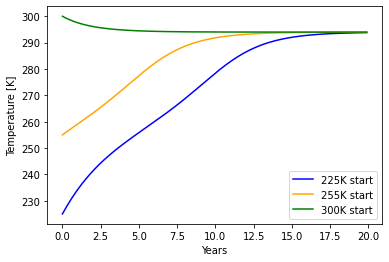

In [ ]:
model = ESM(initial_state=225.0)

model.model_info()

time, temperature_0 = model.integrate(sim_time=20., out_freq=.1, update_state=False, verbose=False)

print('-------------------------------------------------------------------')
model.model_info()


model = ESM(initial_state=255.0)

model.model_info()

time, temperature_1 = model.integrate(sim_time=20., out_freq=.1, update_state=False, verbose=False)

print('-------------------------------------------------------------------')
model.model_info()


model = ESM(initial_state=300.0)

model.model_info()

time, temperature_2 = model.integrate(sim_time=20., out_freq=.1, update_state=False, verbose=False)

print('-------------------------------------------------------------------')
model.model_info()

plt.plot(time, temperature_0, ls='solid', color='blue', label="225K start")
plt.plot(time, temperature_1, ls='solid', color='orange', label="255K start")
plt.plot(time, temperature_2, ls='solid', color='green', label="300K start")

plt.xlabel('Years')
plt.ylabel('Temperature [K]')
plt.legend()

Running stand-alone atmosphere:  True
Surface temperature:  255.0  [K]
Ocean temperature:  245.0  [K]
Surface albedo:  0.5203505387443385  [-]
Land albedo:  0.5189512824004178  [-]
CO2:  400  [ppmv]
ASR:  163.7043611265573  [W/m^2]
OLR:  135.47638754405622  [W/m^2]
NRI:  28.22797358250108  [W/m^2]
DSI:  32.0  [W/m^2]
-------------------------------------------------------------------
Running stand-alone atmosphere:  True
Surface temperature:  255.0  [K]
Ocean temperature:  245.0  [K]
Surface albedo:  0.5203505387443385  [-]
Land albedo:  0.5189512824004178  [-]
CO2:  400  [ppmv]
ASR:  163.7043611265573  [W/m^2]
OLR:  135.47638754405622  [W/m^2]
NRI:  28.22797358250108  [W/m^2]
DSI:  32.0  [W/m^2]
Running stand-alone atmosphere:  True
Surface temperature:  255.0  [K]
Ocean temperature:  245.0  [K]
Surface albedo:  0.5203505387443385  [-]
Land albedo:  0.5189512824004178  [-]
ASR:  163.7043611265573  [W/m^2]
OLR:  167.83029609843933  [W/m^2]
NRI:  -4.125934971882032  [W/m^2]
DSI:  32.0  

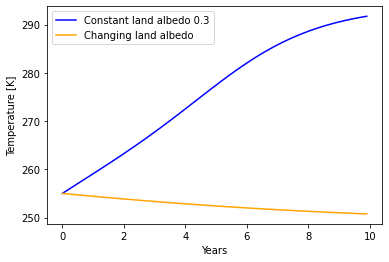

In [ ]:
model = ESM(initial_state=255.0, co2=400)

model.model_info()

time, temperature_0 = model.integrate(sim_time=10., out_freq=.1, update_state=False, verbose=False)

print('-------------------------------------------------------------------')
model.model_info()


model = ESM(initial_state=255.0, co2=0)

model.model_info()

time, temperature_1 = model.integrate(sim_time=10., out_freq=.1, update_state=False, verbose=False)

print('-------------------------------------------------------------------')
model.model_info()


plt.plot(time, temperature_0, ls='solid', color='blue', label="Constant land albedo 0.3")
plt.plot(time, temperature_1, ls='solid', color='orange', label="Changing land albedo")

plt.xlabel('Years')
plt.ylabel('Temperature [K]')
plt.legend()

# Albedo Exercise 1

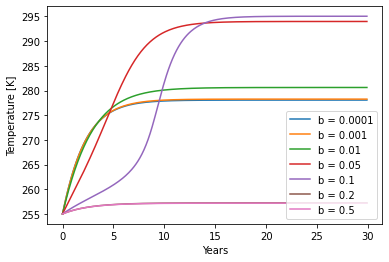

In [ ]:
for param_b in [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.5]:
  model = ESM(initial_state=255.0, albedo_b=param_b)

  time, temperature_0 = model.integrate(sim_time=30., out_freq=.1, update_state=False, verbose=False)

  plt.plot(time, temperature_0, ls='solid', label=f"b = {param_b}")

plt.xlabel('Years')
plt.ylabel('Temperature [K]')
plt.legend()

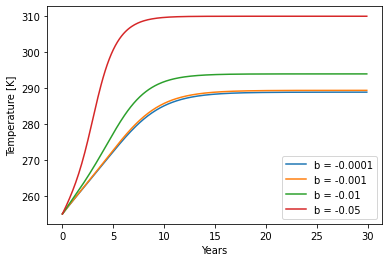

In [ ]:
for param_aco2 in [-0.0001, -0.001, -0.01, -0.05]:
  model = ESM(initial_state=255.0, albedo_carbon_coeff=param_aco2)

  time, temperature_0 = model.integrate(sim_time=30., out_freq=.1, update_state=False, verbose=False)

  plt.plot(time, temperature_0, ls='solid', label=f"b = {param_aco2}")

plt.xlabel('Years')
plt.ylabel('Temperature [K]')
plt.legend()

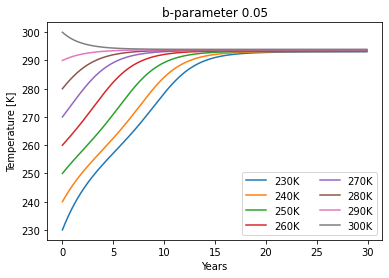

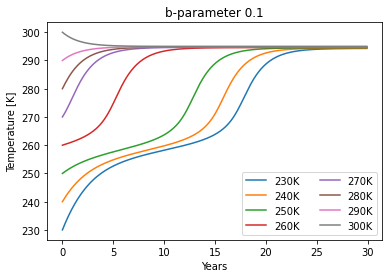

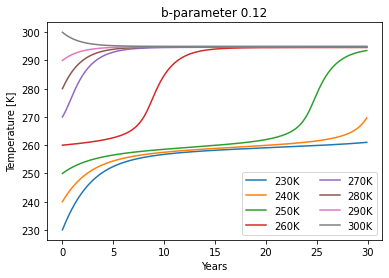

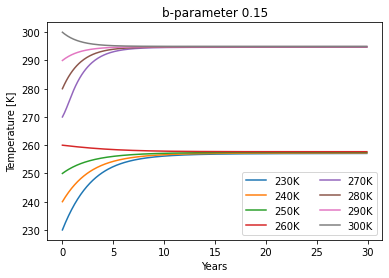

In [ ]:
for albedo_b in [0.05, 0.1, 0.12, 0.15]:
    for t_init in np.arange(230,301,10):
        model = ESM(initial_state=(t_init, t_init-10), albedo_b=albedo_b)

        time, temperature_0 = model.integrate(sim_time=30., out_freq=.1, update_state=False, verbose=False)

        plt.plot(time, temperature_0[:, 0], ls='solid', label=f"{t_init}K")


    plt.xlabel('Years')
    plt.ylabel('Temperature [K]')
    plt.title(f'b-parameter {albedo_b}')
    plt.legend(ncol=2)
    plt.show()

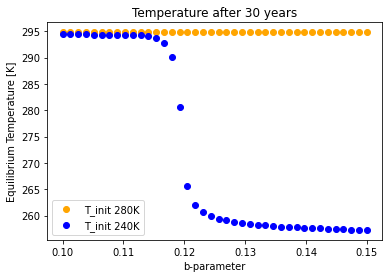

In [12]:
colors = ['orange', 'blue', 'green']
for i, t_init in enumerate([280, 240]):
    for j, albedo_b in enumerate(np.linspace(0.1, 0.15, 40)):

        model = ESM(initial_state=(t_init, t_init-10), albedo_b=albedo_b)

        time, temperature_0 = model.integrate(sim_time=30., out_freq=.1, update_state=False, verbose=False)

        if j == 0:
            plt.scatter(albedo_b, temperature_0[-1, 0], c=colors[i], ls='solid', label=f"T_init {t_init}K")
        else:
            plt.scatter(albedo_b, temperature_0[-1, 0], c=colors[i], ls='solid')


plt.xlabel('b-parameter')
plt.ylabel('Equilibrium Temperature [K]')
plt.title('Temperature after 30 years')
plt.legend()
plt.show()

# Albedo Exercise 2

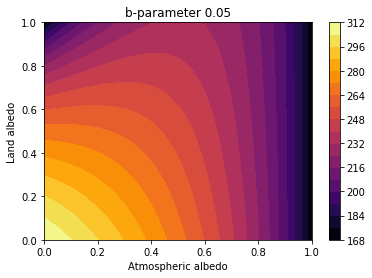

In [ ]:
albedos_atm = np.arange(0,1.01,0.05)
albedos_land = np.arange(0,1.01,0.05)
b_param = 0.05

tequis = np.zeros((len(albedos_atm), len(albedos_land)))

for i, albedo_atm in enumerate(albedos_atm):
    for j, albedo_land in enumerate(albedos_land):
        model = ESM(initial_state=255., use_constant_albedo_icefree=True, use_constant_albedo_land=True, albedo_land=albedo_land, albedo_atm=albedo_atm, albedo_b=b_param)

        time, temperature_0 = model.integrate(sim_time=30., out_freq=.1, update_state=False, verbose=False)

        tequis[i, j] = temperature_0[-1]

plt.contourf(albedos_atm, albedos_land, tequis.T, cmap='inferno', levels=20)
plt.colorbar()

plt.xlabel('Atmospheric albedo')
plt.ylabel('Land albedo')
plt.title(f'b-parameter {b_param}')
plt.show()

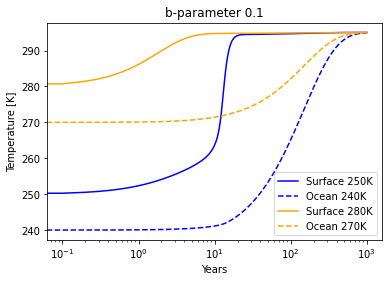

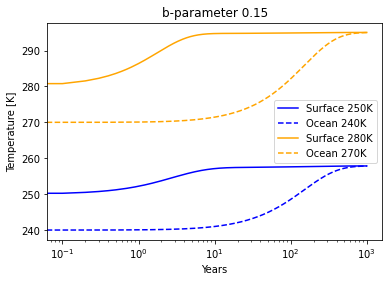

In [ ]:
colors = ['blue', 'orange']

for albedo_b in [0.1, 0.15]:
    for i, t_init in enumerate([250, 280]):
        model = ESM(initial_state=(t_init, t_init-10), albedo_b=albedo_b)

        time, temperature_0 = model.integrate(sim_time=1000., out_freq=.1, update_state=False, verbose=False)

        plt.semilogx(time, temperature_0[:,0], color = colors[i], ls='solid', label=f"Surface {t_init}K")
        plt.semilogx(time, temperature_0[:,1], color = colors[i], ls='--', label=f"Ocean {t_init-10}K")


    plt.xlabel('Years')
    plt.ylabel('Temperature [K]')
    plt.title(f'b-parameter {albedo_b}')
    plt.legend()
    plt.show()

# Deep Ocean Exercise 5

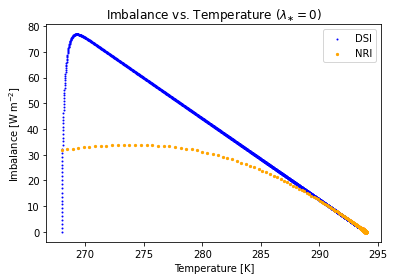

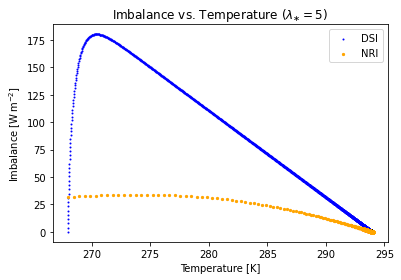

In [13]:
model = ESM(initial_state=(268., 268.))

time, temperature_0 = model.integrate(sim_time=1000., out_freq=.1, update_state=False, verbose=False)

nri = np.zeros(len(temperature_0))
dsi = np.zeros(len(temperature_0))

for i, (ts, td) in enumerate(temperature_0):
    nri[i] = model.compute_NRI(ts)
    dsi[i] = model.compute_DSI(ts, td)

plt.scatter(temperature_0[:,1], dsi, color='blue', s=1, label='DSI')
plt.scatter(temperature_0[:,0], nri, color='orange', s=5, label='NRI')

plt.xlabel('Temperature [K]')
plt.ylabel('Imbalance [$\mathrm{W}\,\mathrm{m}^{-2}$]')
plt.title(r'Imbalance vs. Temperature ($\lambda_{\ast}=0$)')
plt.legend()
plt.show()


model = ESM(initial_state=(268., 268.), transient_rad_resp=5)

time, temperature_0 = model.integrate(sim_time=1000., out_freq=.1, update_state=False, verbose=False)

nri = np.zeros(len(temperature_0))
dsi = np.zeros(len(temperature_0))

for i, (ts, td) in enumerate(temperature_0):
    nri[i] = model.compute_NRI(ts)
    dsi[i] = model.compute_DSI(ts, td)

plt.scatter(temperature_0[:,1], dsi, color='blue', s=1, label='DSI')
plt.scatter(temperature_0[:,0], nri, color='orange', s=5, label='NRI')

plt.xlabel('Temperature [K]')
plt.ylabel('Imbalance [$\mathrm{W}\,\mathrm{m}^{-2}$]')
plt.title(r'Imbalance vs. Temperature ($\lambda_{\ast}=5$)')
plt.legend()
plt.show()

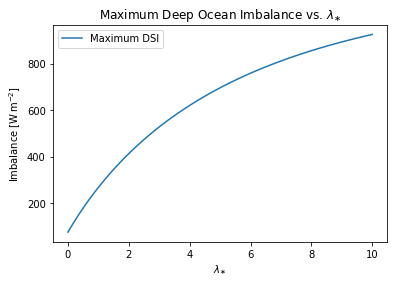

In [14]:
n = 50
dsi_max = np.zeros(n)

for j, lambda_star in enumerate(np.linspace(0, 100, n)):
    model = ESM(initial_state=(268., 268.), transient_rad_resp=lambda_star)

    time, temperature_0 = model.integrate(sim_time=1000., out_freq=.1, update_state=False, verbose=False)

    dsi = np.zeros(len(temperature_0))

    for i, (ts, td) in enumerate(temperature_0):
        dsi[i] = model.compute_DSI(ts, td)

    dsi_max[j] = np.max(dsi)

plt.plot(np.linspace(0, 10, n), dsi_max, label='Maximum DSI')

plt.xlabel(r'$\lambda_{\ast}$')
plt.ylabel('Imbalance [$\mathrm{W}\,\mathrm{m}^{-2}$]')
plt.title(r'Maximum Deep Ocean Imbalance vs. $\lambda_{\ast}$')
plt.legend()
plt.show()

# Deep Ocean Exercise 6

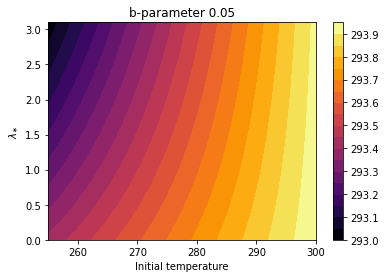

In [ ]:
initial_state = np.linspace(255.0, 300., 25)
lambda_ast = np.linspace(0.0, 3.1, 25)
b_param = 0.05

tequis = np.zeros((len(lambda_ast), len(initial_state)))

for i, tstart in enumerate(initial_state):
    for j, lbd_ast in enumerate(lambda_ast):

        model = ESM(initial_state=[tstart, tstart-10.0], transient_rad_resp=lbd_ast)

        time, Ts = model.integrate(sim_time=30., out_freq=.1, update_state=False, verbose=False)

        tequis[i, j] = Ts[-1, 0]

plt.contourf(initial_state, lambda_ast, tequis.T, cmap='inferno', levels=20)
plt.colorbar()

plt.xlabel('Initial temperature')
plt.ylabel(r'$\lambda_{\ast}$')
plt.title(f'b-parameter {b_param}')
plt.show()

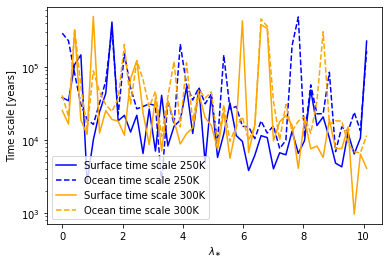

In [ ]:
colors = ['blue', 'orange', 'black']
rad_response = np.linspace(0., 10.1, 50)

eq_timescale=500000.

time_scale_s = np.zeros_like(rad_response)
time_scale_d = np.zeros_like(rad_response)

for i, t_init in enumerate([250, 300]):

    for j, lbd_ast in enumerate(rad_response):

        model = ESM(initial_state=(t_init, t_init), transient_rad_resp=lbd_ast, mixing_scale=6.0)

        time, temp = model.integrate(sim_time=eq_timescale, out_freq=.1, update_state=False, verbose=False)

        _, id_s, _ = np.intersect1d( temp[:, 0], temp[-1, 0], return_indices=True)
        time_scale_s[j] = time[id_s[0]]

        _, id_d, _, = np.intersect1d( temp[:, 1], temp[-1, 1], return_indices=True)
        time_scale_d[j] = time[id_d[0]]

    plt.semilogy(rad_response, time_scale_s, color = colors[i], ls='solid', label=f"Surface time scale {t_init}K")
    plt.semilogy(rad_response, time_scale_d, color = colors[i], ls='--', label=f"Ocean time scale {t_init}K")

plt.ylabel('Time scale [years]')
plt.xlabel(r'$\lambda_{\ast}$')
plt.title('')
plt.legend()
plt.show()

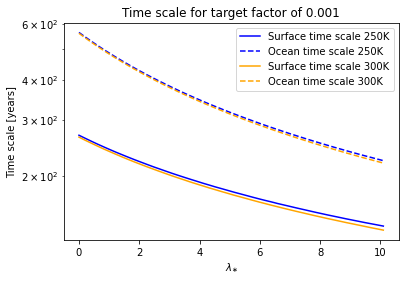

In [27]:
colors = ['blue', 'orange', 'black']
rad_response = np.linspace(0., 10.1, 50)

eq_timescale=5000.
target_factor=0.001

time_scale_s = np.zeros_like(rad_response)
time_scale_d = np.zeros_like(rad_response)

for i, t_init in enumerate([250, 300]):

    for j, lbd_ast in enumerate(rad_response):

        model = ESM(initial_state=(t_init, t_init), transient_rad_resp=lbd_ast, mixing_scale=6.0)

        time, temp = model.integrate(sim_time=eq_timescale, out_freq=.1, update_state=False, verbose=False)

        temp_s = temp[:, 0]
        temp_d = temp[:, 1]
        
        time_scale_s[j] = time[np.abs(temp_s - temp_s[-1]) < np.abs(temp_s[0] - temp_s[-1])*target_factor][0]
        time_scale_d[j] = time[np.abs(temp_d - temp_d[-1]) < np.abs(temp_d[0] - temp_d[-1])*target_factor][0]

    plt.semilogy(rad_response, time_scale_s, color = colors[i], ls='solid', label=f"Surface time scale {t_init}K")
    plt.semilogy(rad_response, time_scale_d, color = colors[i], ls='--', label=f"Ocean time scale {t_init}K")

plt.ylabel('Time scale [years]')
plt.xlabel(r'$\lambda_{\ast}$')
plt.title(f'Time scale for target factor of {target_factor}')
plt.legend()
plt.show()